# Analyse effect of adding random seed genes

In [1]:
import pandas as pd
import pickle

In [2]:
phenotypes = [  "Apolipoprotein_A",
  "Apolipoprotein_B",
  "Calcium",
  "Cholesterol_statin_corrected",
  "HDL_cholesterol",
  "IGF_1",
  "LDL_direct_statin_corrected",
  "Lymphocyte_percentage",
  "Mean_corpuscular_volume",
  "Mean_platelet_thrombocyte_volume",
  "Mean_reticulocyte_volume",
  "Neutrophill_count",
  "Platelet_count",
  "Platelet_crit",
  "Platelet_distribution_width",
  "Red_blood_cell_erythrocyte_count",
  "SHBG",
  "Standing_height",
  "Total_bilirubin",
  "Triglycerides",
  "Urate"]


In [3]:
len(phenotypes)

21

In [4]:
base_exp_dir = './' # directory where you want to set up the experiment

In [5]:
exp_config = {'p_genes_random': 0.2,
            'min_p_quantile': 0.0,
            'max_p_quantile': 0.5}

exps = 5 #10
cv_splits = 5

In [ ]:
p_genes_random = exp_config['p_genes_random']
min_p_quantile = exp_config['min_p_quantile']
max_p_quantile = exp_config['max_p_quantile']

protein_coding_genes = pd.read_parquet(f'{base_exp_dir}/base/protein_coding_genes.parquet')


all_seed = {i : [] for i in range(exps)}
added_gene_pval = {i : [] for i in range(exps)}

for idx in range(exps):
    exp_dir = f'{base_exp_dir}/sg_set_{idx}'
    print(exp_dir)
    for p in phenotypes: 
        print(p)
        seed_gene_file = f'{base_exp_dir}/base/cv_split0/deeprvat/{p}/deeprvat/seed_genes.parquet'
        this_seed = pd.read_parquet(seed_gene_file)
        if 'random_gene' in this_seed.columns:
            this_seed = this_seed.query('random_gene == False')
        else:
            this_seed = this_seed.assign(random_gene = False)
        n_genes_random = max(round(len(this_seed) * p_genes_random), 1)
        print(f'number of random genes that will be sampled: {n_genes_random}')

        # get baseline p-values of all genes
        this_base_file = f'{base_exp_dir}/base/baseline_results/{p}/eval/all_associations.parquet'
        this_base = pd.read_parquet(this_base_file)

        #sample new genes
        min_pval = this_base.query('EAC >= 50')[['gene', 'method', 'pval']].groupby('gene').min('pval').sort_values('pval').query('pval < 0.5')                                                                                                        
        #min_pval = this_base.query('EAC >= 50')[['gene', 'method', 'pval']].groupby('gene').min('pval').sort_values('pval')
        new_genes = min_pval.reset_index()\
            .sample(n_genes_random)

        display(new_genes)

        gene_pval = new_genes.assign(phenotype=p)
        
        new_genes = new_genes['gene']

        seed_random = protein_coding_genes.query('id in @new_genes')\
            .assign(significant = True, correction_method = 'Bonferroni', random_gene = True)
            # addd columns such that they are the same as in this_seed
            # has to updated 
            
        seed_combined = pd.concat([this_seed, seed_random]).assign(phenotype = p)

        for split in range(cv_splits):
            seed_combined.to_parquet(f'{exp_dir}/cv_split{split}/deeprvat/{p}/deeprvat/seed_genes.parquet')

        print(len(seed_combined))
        all_seed[idx].append(seed_combined)
        added_gene_pval[idx].append(gene_pval)
    all_seed[idx] = pd.concat(all_seed[idx])
    added_gene_pval[idx] = pd.concat(added_gene_pval[idx])


with open(f'{base_exp_dir}/added_gene_pval_dict.pkl','wb') as f:
    pickle.dump(added_gene_pval, f)

with open(f'{base_exp_dir}/all_seed_dict.pkl','wb') as f:
    pickle.dump(all_seed, f)

Review Results

In [6]:
import pickle
base_exp_dir = './'
with open(f'{base_exp_dir}/added_gene_pval_dict.pkl','rb') as f:
    added_gene_pval_dict = pickle.load(f)

with open(f'{base_exp_dir}/all_seed_dict.pkl','rb') as f:
    all_seed_dict = pickle.load(f)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()

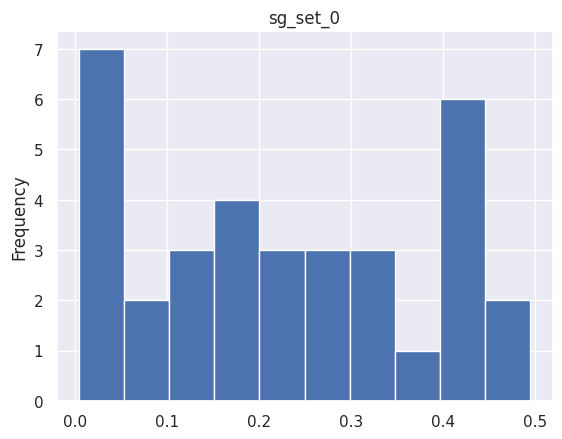

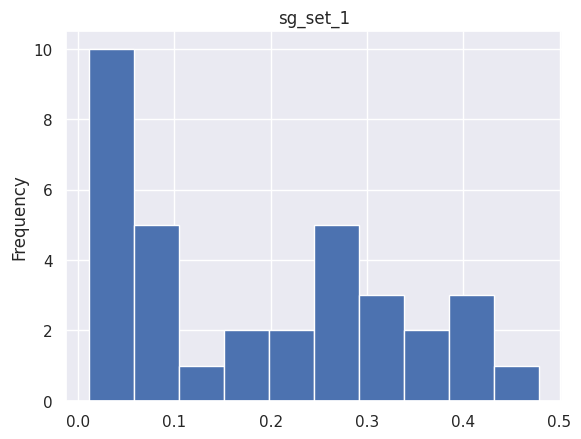

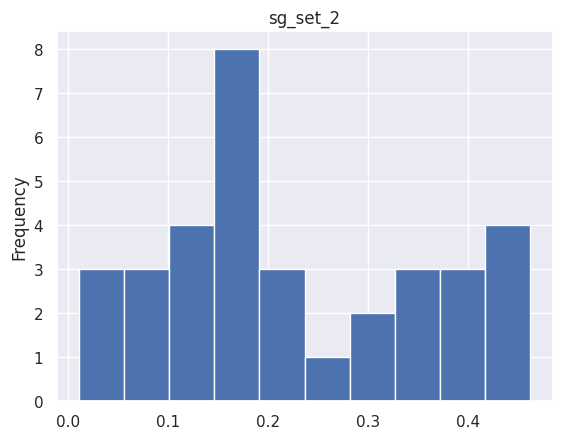

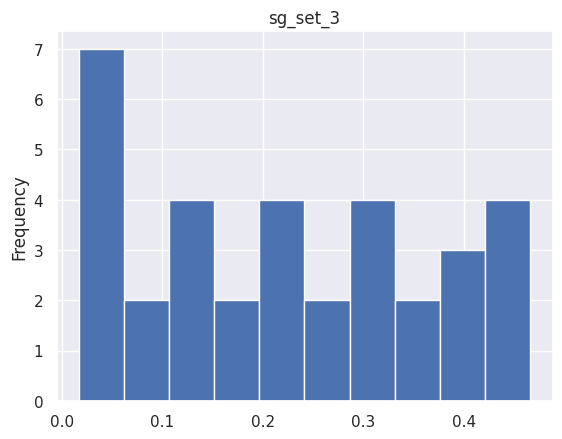

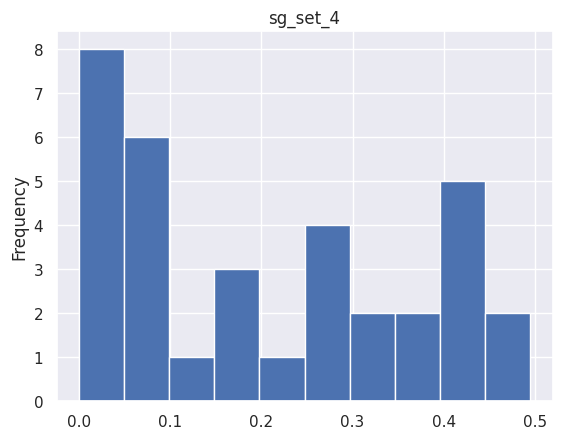

In [9]:
for i in range(5):
    added_gene_pval[i]["pval"].plot.hist() 
    plt.title(f"sg_set_{i}")
    plt.show()